In [ ]:
import os

Find data [here to start](https://www.kaggle.com/c/dogs-vs-cats/data)

In [ ]:
# Install Kaggle API
!pip install -q kaggle

In [ ]:
os.environ['KAGGLE_USERNAME'] = "xxxxx"
os.environ['KAGGLE_KEY'] = "xxxxxxxxxxxxxxxxxxxxxx"

In [ ]:
!kaggle competitions download -c dogs-vs-cats

In [ ]:
!unzip dogs-vs-cats.zip

In [ ]:
!unzip train.zip

In [ ]:
!unzip test1.zip

In [ ]:
!rm train.zip

In [ ]:
!rm test1.zip

In [ ]:
!ls

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from functools import partial
from tensorflow.keras import models

from sklearn.model_selection import train_test_split

PS :  you can use image_dataset_from_directory only if your data is organized by class in directories.

In [ ]:
!mkdir -p data/train/cat data/train/dog data/val/cat data/val/dog data/test

In [ ]:
import os
import shutil

# Move training data
train_files = os.listdir('./train')
train_cats = [f for f in train_files if f.startswith('cat')]
train_dogs = [f for f in train_files if f.startswith('dog')]

# Split into train and validation
train_cats, val_cats = train_test_split(train_cats, test_size=0.2, random_state=42)
train_dogs, val_dogs = train_test_split(train_dogs, test_size=0.2, random_state=42)

# Move files
for cat in train_cats:
    shutil.move(f'./train/{cat}', f'./data/train/cat/{cat}')
for dog in train_dogs:
    shutil.move(f'./train/{dog}', f'./data/train/dog/{dog}')
for cat in val_cats:
    shutil.move(f'./train/{cat}', f'./data/val/cat/{cat}')
for dog in val_dogs:
    shutil.move(f'./train/{dog}', f'./data/val/dog/{dog}')

# Move test data
test_files = os.listdir('./test1')
for file in test_files:
    shutil.move(f'./test1/{file}', f'./data/test/{file}')

In [2]:
IMG_SIZE = (150, 150)
BATCH_SIZE = 32

# Load training data
train_dataset = tf.keras.utils.image_dataset_from_directory(
    './data/train',
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label_mode='binary'
)

# Load validation data
val_dataset = tf.keras.utils.image_dataset_from_directory(
    './data/val',
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label_mode='binary'
)

# Load test data (without labels)
test_dataset = tf.keras.utils.image_dataset_from_directory(
    './data/test',
    shuffle=False,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label_mode=None
)

Found 20000 files belonging to 2 classes.


2024-09-01 23:25:38.598232: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-09-01 23:25:38.598260: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-09-01 23:25:38.598272: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-09-01 23:25:38.598287: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-01 23:25:38.598310: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 5000 files belonging to 2 classes.
Found 12500 files.


In [3]:
# Automatically choose the best buffer size
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [4]:
# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(150, 150, 3)),
    
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.4),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

# Get summary
model.summary()

/Users/ismailsmac/.pyenv/versions/3.10.12/envs/Artefact/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 34, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18496)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,367,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,425,217 (9.25 MB)

 Trainable params: 2,424,641 (9.25 MB)

 Non-trainable params: 576 (2.25 KB)

In [5]:
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=15,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/15


2024-09-01 23:26:35.699181: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


625/625 ━━━━━━━━━━━━━━━━━━━━ 133s 199ms/step - accuracy: 0.6308 - loss: 0.7601 - val_accuracy: 0.5990 - val_loss: 0.8342 - learning_rate: 0.0010
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 234s 375ms/step - accuracy: 0.7517 - loss: 0.5086 - val_accuracy: 0.7564 - val_loss: 0.4869 - learning_rate: 0.0010
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 126s 202ms/step - accuracy: 0.8138 - loss: 0.4093 - val_accuracy: 0.8078 - val_loss: 0.4311 - learning_rate: 0.0010
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 128s 205ms/step - accuracy: 0.8394 - loss: 0.3597 - val_accuracy: 0.8170 - val_loss: 0.4120 - learning_rate: 0.0010
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 292s 467ms/step - accuracy: 0.8632 - loss: 0.3175 - val_accuracy: 0.7098 - val_loss: 0.6111 - learning_rate: 0.0010
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 127s 203ms/step - accuracy: 0.8770 - loss: 0.2900 - val_accuracy: 0.8354 - val_loss: 0.3673 - learning_rate: 0.0010
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 124s 197ms/step - accuracy: 0.8905 

In [6]:
# Evaluate on training set
train_loss, train_accuracy = model.evaluate(train_dataset)
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Training Loss: {train_loss:.4f}")

# Evaluate on validation set
val_loss, val_accuracy = model.evaluate(val_dataset)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 39s 61ms/step - accuracy: 0.9474 - loss: 0.1555
Training Accuracy: 0.9484
Training Loss: 0.1537
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - accuracy: 0.8531 - loss: 0.3365
Validation Accuracy: 0.8554
Validation Loss: 0.3422


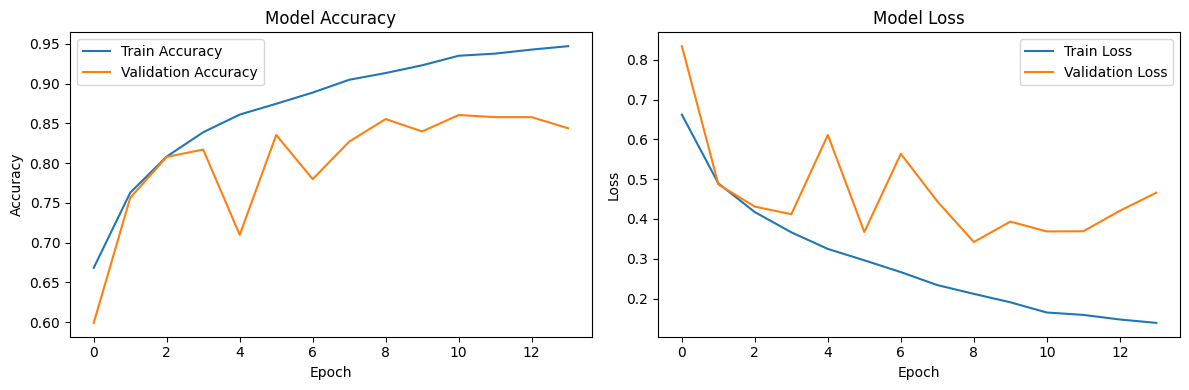

In [13]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

We can notice the gap between training and validation. But let's see the results anyways.

In [14]:
# Make predictions on test set
predictions = model.predict(test_dataset)

# Convert predictions to binary (0 or 1)
binary_predictions = (predictions > 0.5).astype(int)

# Get the list of test image filenames
test_dir = './data/test'
test_filenames = sorted(os.listdir(test_dir))  # Sort to ensure correct order

df = pd.DataFrame({
    'id': [os.path.splitext(filename)[0] for filename in test_filenames],
    'label': binary_predictions.flatten()
})
df.head()

391/391 ━━━━━━━━━━━━━━━━━━━━ 22s 56ms/step


,id,label
0,1,1
1,10,0
2,100,1
3,1000,1
4,10000,1


In [10]:
# Print distribution of predictions (PS: 1 for dogs, 0 for cats)
print("Distribution of predictions:")
print(pd.Series(binary_predictions.flatten()).value_counts(normalize=True))

Distribution of predictions:
1    0.5032
0    0.4968
Name: proportion, dtype: float64


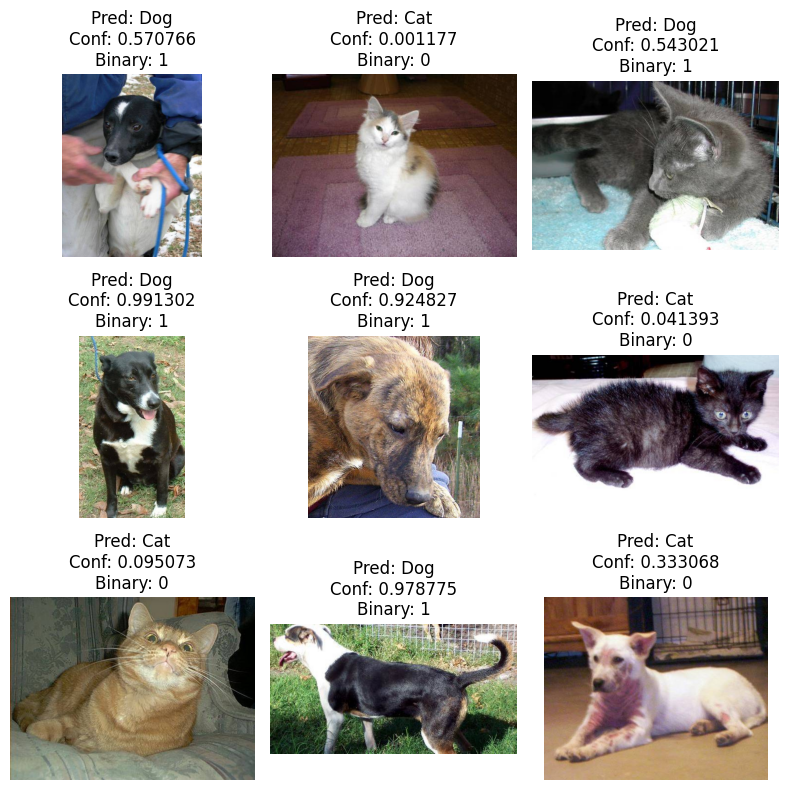

In [15]:
# Visualize 9 predictions
plt.figure(figsize=(8, 8))
for i in range(9):  # Show 9 images
    plt.subplot(3, 3, i+1)
    
    # Get the filename from the test_filenames list
    filename = test_filenames[i]
    
    # Get the confidence from the predictions array
    confidence = predictions[i][0]  # predictions is a 2D array, so we need to access the first (and only) element
    
    img_path = os.path.join(test_dir, filename)
    img = plt.imread(img_path)
    plt.imshow(img)
    
    pred_class = 'Dog' if binary_predictions[i] == 1 else 'Cat'
    
    plt.title(f"Pred: {pred_class}\nConf: {confidence:.6f}\nBinary: {binary_predictions[i][0]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

The model is still not perfect but the results are promising so far. Next, i will try to get even better results using ImageDataGenerator that could solve overfitting issue. 

In [16]:
# Hyperparameters
IMG_HEIGHT, IMG_WIDTH = 200, 200
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.001

# Data Augmentation and Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Load and prepare the data
train_generator = train_datagen.flow_from_directory(
    'data/train',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    'data/val',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

# Trying a different model Architecture
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
optimizer = Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.2, patience=5, min_lr=0.00001)
checkpoint = ModelCheckpoint('./checkpoint/best_model.keras', save_best_only=True)

model.summary()

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


/Users/ismailsmac/.pyenv/versions/3.10.12/envs/Artefact/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 198, 198, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 198, 198, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 99, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 97, 97, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 97, 97, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 46, 46, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 46, 46, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 23, 23, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 21, 21, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 21, 21, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     6,554,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,798,913 (25.94 MB)

 Trainable params: 6,797,185 (25.93 MB)

 Non-trainable params: 1,728 (6.75 KB)

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

In [ ]:
# Load the best model
best_model = tf.keras.models.load_model('./checkpoint/best_model.keras')

# Evaluate the model
test_generator = test_datagen.flow_from_directory(
    'data/test',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

test_loss, test_accuracy = best_model.evaluate(test_generator)
print(f"Test accuracy: {test_accuracy:.4f}")

# Make predictions
predictions = best_model.predict(test_generator)
binary_predictions = (predictions > 0.5).astype(int)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = test_generator.next()[0][0]
    plt.imshow(img)
    pred_class = 'Dog' if binary_predictions[i] == 1 else 'Cat'
    confidence = predictions[i][0]
    plt.title(f"Pred: {pred_class}\nConf: {confidence:.4f}")
    plt.axis('off')
plt.tight_layout()
plt.show()